### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="qwen-qwq-32b",
)

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

system_message = SystemMessage(
    content="You are a helpful assistant that can perform arithmetic operations."
)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke([system_message] + state['messages'])}

In [6]:
# Graph

builder = StateGraph(MessagesState)

builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', tools_condition)

builder.add_edge('tools', 'assistant')

memory = MemorySaver()

graph = builder.compile(interrupt_before=['assistant'], checkpointer= memory)



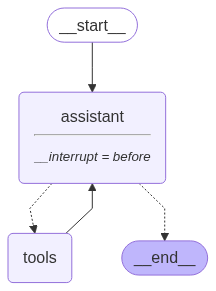

In [7]:
graph

In [8]:
initial_input = {'messages': [HumanMessage(content="What is 2 * 2?")]}
thread = {'configurable': {'thread_id': 1}}

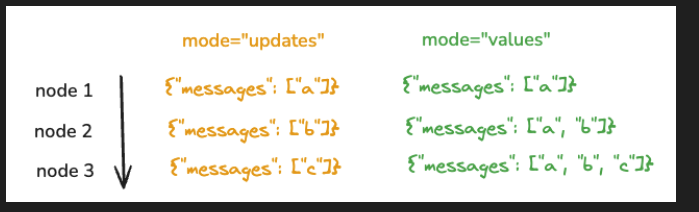

In [9]:
for event in graph.stream(initial_input,thread, stream_mode='values'):
  event['messages'][-1].pretty_print()
    

================================ Human Message =================================

What is 2 * 2?


In [10]:
current_graph_state = graph.get_state(thread)
current_graph_state.next

('assistant',)

In [11]:
for event in graph.stream(None, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()


================================ Human Message =================================

What is 2 * 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (d6jjdc6jm)
 Call ID: d6jjdc6jm
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


### till now we were not passing anything as a human feedback but now we will pass human feedback

In [12]:
initial_input = {'messages': [HumanMessage(content="What is 2 + 2?")]}

thread = {'configurable': {'thread_id': '1'}}
for event in graph.stream(initial_input, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

What is 2 + 2?


In [13]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, actually multiply 15 and 5!")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04d0b4-1619-6154-8001-c70b40dc3c3e'}}

In [14]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
  m.pretty_print()

================================ Human Message =================================

What is 2 + 2?
================================ Human Message =================================

No, actually multiply 15 and 5!


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 15 and 5!
================================== Ai Message ==================================
Tool Calls:
  multiply (14pkakbnz)
 Call ID: 14pkakbnz
  Args:
    a: 15
    b: 5
================================= Tool Message =================================
Name: multiply

75


In [16]:
state=graph.get_state(thread)
state.next

('assistant',)

In [17]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

75
================================== Ai Message ==================================

The result of multiplying 15 by 5 is **75**.


## Taking input from user

In [18]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [19]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

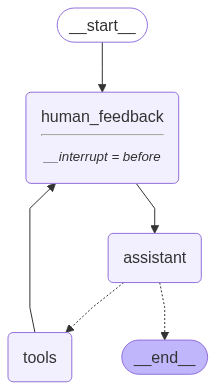

In [22]:
graph

In [23]:
initial_input = {'messages': [HumanMessage(content="What is 2 + 2?")]}

thread = {'configurable': {'thread_id': '3'}}

for event in graph.stream(initial_input, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is 2 + 2?


In [24]:
## get user input

user_input=input("Tell me how you want to update the state:")

graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04d0b9-2141-6630-8003-f0823455d2a5'}}

In [25]:
for event in graph.stream(None, thread, stream_mode='values'):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

what are we doing
================================== Ai Message ==================================

I'm here to help with arithmetic operations using the provided tools: addition, multiplication, and division. For example, I can calculate expressions like "What is 10 * 5?" or "What happens when you divide 20 by 4?". Let me know what math problem you'd like to solve!


In [26]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm here to help with arithmetic operations using the provided tools: addition, multiplication, and division. For example, I can calculate expressions like "What is 10 * 5?" or "What happens when you divide 20 by 4?". Let me know what math problem you'd like to solve!
